In [1]:
from HF_helper_2 import BasisFunction, S_ab, V_ab, T_ab, TwoE
'''
The intergral and basis-sets tools are written Joshua Goings under the following licence:

# BSD 3-Clause License
# Copyright (c) 2021, Joshua Goings
# All rights reserved.

'''
import numpy as np


In [2]:
#######
#H-He+
R_i=[[0,0,0],[0,0,1.5517]]
Z_i=[1.0,2.0]
N=2 #Number of electrons

global basis_set
basis_set=[]
basis_set.append ( BasisFunction(origin=[0,0,0],shell=[0,0,0],exps=[0.4166],coefs=[1]) )
basis_set.append ( BasisFunction(origin=[0,0,1.5517],shell=[0,0,0],exps=[0.7739],coefs=[1]) )
######

#############
#Hydrgen atom
# R_i=[[0,0,0]]
# Z_i=[1.0]
# N=2 #Number of electrons

# exps=[13.00773 ,1.962079, 0.444529, 0.1219492]
# basis_set=[]
# for a in exps:
#     basis_set.append ( BasisFunction(origin=[0,0,0],shell=[0,0,0],exps=[a],coefs=[1]) )
#####

M=len(basis_set)
global index;index=range(M)

global F;F=np.zeros([M,M])     #FOCK-MATRIX
global T;T=np.zeros([M,M])     #KINETIC ENERGY MATRIX
global S;S=np.zeros([M,M])     #OVERLAP MATRIX
global V;V=np.zeros([M,M])     #NECLOUS ATTRACTION MATRIX
global J;J=np.zeros([M,M,M,M]) #COULOMB ELEMENTS
global K;K=np.zeros([M,M,M,M]) #EXCHANGE ELEMENTS
global P;P=np.zeros([M,M])     #DENSITY MATRIX
global C;C=np.zeros([M,M])     #COEFFICIENT MATRIX
global eps;eps=np.zeros([M])   #ORBITAL ENERGIES (EIGENVALUES TO THE FOCK-MATRIX)

#FILLING IN THE MATRICES
#One electron integrals
for a,basis_func_a in zip(index,basis_set):
    for b,basis_func_b in zip(index,basis_set):
        S[a,b]=S_ab(basis_func_a,basis_func_b)
        T[a,b]=T_ab(basis_func_a,basis_func_b)
        for R,Z in zip(R_i,Z_i):
            V[a,b] -= Z*V_ab(basis_func_a,basis_func_b,R)
        
#Two electron integrals
for a,basis_func_a in zip(index,basis_set):
    for b,basis_func_b in zip(index,basis_set):
        for c,basis_func_c in zip(index,basis_set):
            for d,basis_func_d in zip(index,basis_set):
                J[a,b,c,d]=TwoE(basis_func_a,basis_func_b,basis_func_c,basis_func_d)
                K[a,b,c,d]=TwoE(basis_func_a,basis_func_b,basis_func_c,basis_func_d)





In [4]:
def construct_X():
    #Construct "diagonilzer"  X=S^(-1/2)
    D,U =np.linalg.eig(S)
    D=np.diag(1/D**0.5)
    UD=np.matmul(U,D)
    global X;X=np.matmul(UD,U.T)

def calculate_F():
    global F
    for i in range(M):
        for j in range(M):
            JK=0
            for k in range(M):
                for l in range(M):
                    JK += P[k,l]*(J[i,j,k,l]   -0.5*K[i,j,k,l]) 
            F[i,j]=T[i,j]+V[i,j]+JK 

def solve_F():
    global C
    global eps
    Fp=np.matmul(X,F)
    Fp=np.matmul(Fp,X)
    eps,eigV=eigenval(Fp)
    C=np.matmul(X,eigV)
    

def update_P():
    global P
    Pold=P
    Pnew=P*0.0
    for i in range(M):
        for j in range(M):
            for k in range(int(N/2)):
                Pnew[i,j] += 2*C[i,k]*C[j,k]

    P=0.8*Pold+0.2*Pnew
    
def get_total_E():
    total_E=0.0
    for i in range(M):
        for j in range(M):
            total_E += 0.5*P[i,j]*(T[i,j] +V[i,j] + F[i,j])
    return total_E
    
def eigenval(A):
    eigenValues, eigenVectors = np.linalg.eig(A)
    idx = eigenValues.argsort()    
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]
    return eigenValues,eigenVectors

def txt2mat(A):

    A=A.split("\n")
    N=len(A)-2
    A_mat=np.zeros([N,N])


    i=0
    for a in A:
        if a != '':
            a=a.split(" ")
            j=0
            for aa in a:
                if aa != '':
                    A_mat[i,j]=float(aa)
                    j=j+1
            i+=1
    return A_mat


In [5]:
construct_X()
E=[]
for steps in range(100):
    calculate_F()
    solve_F()
    update_P()
    tot_E=get_total_E()
    E.append(tot_E)

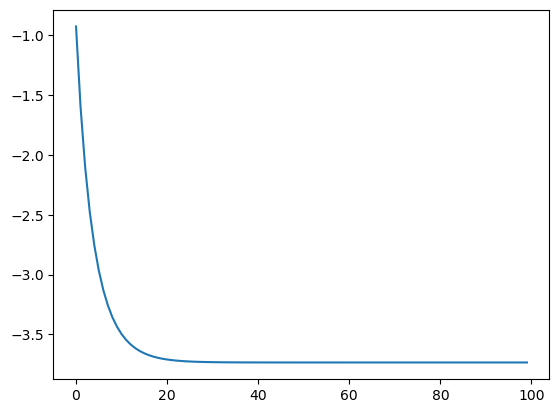

In [6]:
import matplotlib.pyplot as plt
plt.plot(E)


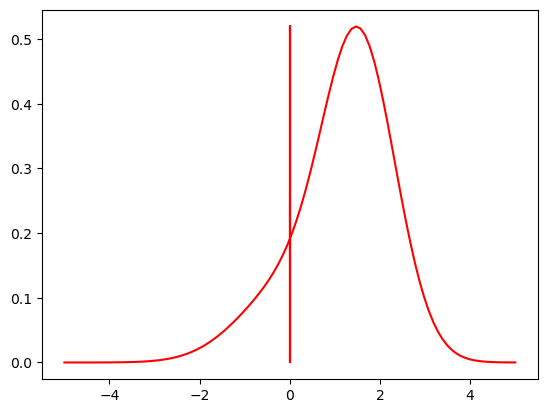

In [7]:
def eval_rho(r):
    '''
    Takes a list of distance a returns the electron density at them.
    '''
    rhos=[]
    for rr in r:
        rho=0.0
        for elec in range(int(N/2)):
            for a,basis_func in zip(index,basis_set):
                d=np.linalg.norm( basis_func.origin-rr)
                for c,ex in zip(basis_func.coefs,basis_func.exps):
                    rho += C[a,elec]*basis_func.norm*c*np.exp( -d**2*ex  ) 
            rhos.append(rho)
    return(rhos)


r=[]
for x in np.linspace(-5,5, 100):
    r.append([0,0,x])

plt.plot(r, eval_rho(r), color='red')

